### 데이터 불러오고, 이전 데이터 추정

In [457]:
# 매크로 데이터 불러오기
import pandas as pd

macro = pd.read_csv("macro.csv", index_col = 0)
macro["date"] = pd.to_datetime(macro["date"])
macro.head()

,date,wti,vix,diff,jpy_krw,usd_krw,ism,china_pmi
0,2005-02-01,47.12,12.03,0.736,9.9161,1028.50,56.8,54.7
1,2005-02-02,46.69,11.66,0.706,9.9151,1027.85,56.8,54.7
2,2005-02-03,46.45,11.79,0.697,9.8172,1025.50,56.8,54.7
3,2005-02-04,46.48,11.21,0.661,9.8319,1023.50,56.8,54.7
4,2005-02-07,45.28,11.73,0.627,9.8169,1029.50,56.8,54.7


In [458]:
# ETF 데이터
import FinanceDataReader as fdr

sp500_etf = fdr.DataReader("143850", "2010-01-01")
sp500_etf = sp500_etf.reset_index()
sp500_etf.columns = ["date", "open", "high", "low", "close", "volume", "change"]
sp500_etf.head()

,date,open,high,low,close,volume,change
0,2011-07-18,13440,13440,13395,13420,6638,NaN
1,2011-07-19,13400,13400,13350,13350,55,-0.005216
2,2011-07-20,13455,13570,13455,13530,24,0.013483
3,2011-07-21,13485,13570,13485,13570,658,0.002956
4,2011-07-22,13710,13765,13710,13765,41,0.014370


In [459]:
# S&P500 데이터

sp500 = fdr.DataReader("US500", "2010-01-01")
sp500 = sp500.reset_index()
sp500.columns = ["date", "close", "open", "high", "low", "volume", "change"]
sp500["high_change"] = (sp500["high"] / sp500["close"]) - 1
sp500["low_change"] = (sp500["low"] / sp500["close"]) - 1
sp500.head()

,date,close,open,high,low,volume,change,high_change,low_change
0,2010-01-04,1132.99,1116.56,1133.87,1116.56,0.0,0.0160,0.000777,-0.014501
1,2010-01-05,1136.52,1132.66,1136.63,1129.66,0.0,0.0031,0.000097,-0.006036
2,2010-01-06,1137.14,1135.71,1139.19,1133.95,0.0,0.0005,0.001803,-0.002805
3,2010-01-07,1141.69,1136.27,1142.46,1131.32,0.0,0.0040,0.000674,-0.009083
4,2010-01-08,1144.98,1140.52,1145.39,1136.22,0.0,0.0029,0.000358,-0.007651


In [460]:
# 2011년 7월 18일 이전 데이터 추정
use_sp500 = sp500[sp500["date"] <= "2011-07-18"].sort_values(by = "date", ascending = False).reset_index(drop = True)

sp500_list = [13420]
for i in range(0, len(use_sp500)):
    estimate = sp500_list[-1] / (1 + use_sp500["change"][i])
    sp500_list.append(estimate)

sp500_list = sp500_list[:388]

low_list = []
high_list = []
for j in range(1, len(sp500_list)):
    low_estimation = sp500_list[j] * (1 + use_sp500["low_change"][j])
    high_estimation = sp500_list[j] * (1 + use_sp500["high_change"][j])

    low_list.append(low_estimation)
    high_list.append(high_estimation)

In [461]:
# 추정 데이터와 ETF 데이터 합치기
df_estimation = pd.DataFrame()
df_estimation["date"] = use_sp500["date"][1:]
df_estimation["high"] = high_list
df_estimation["low"] = low_list
df_estimation["close"] = sp500_list[1:]

df_estimation = df_estimation.sort_values(by = "date", ascending = True).reset_index(drop = True)

sp500_etf = pd.concat([df_estimation, sp500_etf], axis = 0).reset_index(drop = True)
sp500_etf.head()

,date,high,low,close,open,volume,change
0,2010-01-04,11656.647716,11478.693831,11647.600956,NaN,NaN,NaN
1,2010-01-05,11684.839347,11613.186012,11683.708519,NaN,NaN,NaN
2,2010-01-06,11710.623925,11656.757872,11689.550374,NaN,NaN,NaN
3,2010-01-07,11744.223997,11629.707379,11736.308575,NaN,NaN,NaN
4,2010-01-08,11774.558652,11680.291456,11770.343870,NaN,NaN,NaN


### 기술 지표 데이터 산출

In [462]:
# true range

high_low = []
high_close = []
low_close = []

for i in range(0, len(sp500_etf)):
    
    # |당일 고가 - 당일 저가|
    today_high = sp500_etf["high"][i]
    today_low = sp500_etf["low"][i]
    val_high_low = abs(today_high - today_low)
    high_low.append(val_high_low)
    
    # |당일 고가 - 전일 종가|
    if i - 1 == -1:
        recent_close = sp500_etf["close"][i]
    
    else:
        recent_close = sp500_etf["close"][i - 1]
        
    val_high_close = abs(today_high - recent_close)
    high_close.append(val_high_close)
    
    # |당일 저가 - 전일 종가|
    val_low_close = abs(today_low - recent_close)
    low_close.append(val_low_close)
    
true_range = []

for j in range(0, len(sp500_etf)):
    tr_val = max(high_low[j], high_close[j], low_close[j])
    true_range.append(tr_val)
    
sp500_etf["true_range"] = true_range

In [463]:
# nomalized average true range
import numpy as np

natr = []

for i in range(0, len(sp500_etf)):
    if i + 1 < 14:
        natr_val = np.nan
    
    else:
        natr_val = sp500_etf["true_range"][i-13:i+1].sum() / sp500_etf["close"][i] * 100
        
    natr.append(natr_val)
    
sp500_etf["NATR"] = natr

In [464]:
# moving average (5, 15, 30)

ma5 = []

for i in range(0, len(sp500_etf)):
    if i + 1 < 5:
        ma5_val = np.nan
        
    else:
        ma5_val = sp500_etf["close"][i-4:i+1].sum() / 5
        
    ma5.append(ma5_val)
    
ma15 = []

for j in range(0, len(sp500_etf)):
    if j + 1 < 15:
        ma15_val = np.nan
        
    else:
        ma15_val = sp500_etf["close"][j-14:j+1].sum() / 15
        
    ma15.append(ma15_val)
    
ma30 = []

for k in range(0, len(sp500_etf)):
    if k + 1 < 30:
        ma30_val = np.nan
        
    else:
        ma30_val = sp500_etf["close"][k-29:k+1].sum() / 30
        
    ma30.append(ma30_val)
    
sp500_etf["MA5"] = ma5
sp500_etf["MA15"] = ma15
sp500_etf["MA30"] = ma30

In [465]:
# bollinger band (upper, middle, lower band, band width)

middle_band = []

for i in range(0, len(sp500_etf)):
    if i + 1 < 20:
        middle = np.nan
        
    else:
        middle = sp500_etf["close"][i-19:i+1].sum() / 20
        
    middle_band.append(middle)
    
upper_band = []
lower_band = []

for j in range(0, len(sp500_etf)):
    if j + 1 < 20:
        upper = np.nan
        lower = np.nan
        
    else:
        upper = middle_band[j] + (2 * sp500_etf["close"][j-19:j+1].std())
        lower = middle_band[j] - (2 * sp500_etf["close"][j-19:j+1].std())
        
    upper_band.append(upper)
    lower_band.append(lower)
    
sp500_etf["upper_band"] = upper_band
sp500_etf["middle_band"] = middle_band
sp500_etf["lower_band"] = lower_band
sp500_etf["band_width"] = sp500_etf["upper_band"] - sp500_etf["lower_band"]

In [466]:
# on balance volume

obv = []

for i in range(0, len(sp500_etf)):
    if i - 1 == -1:
        obv_val = sp500_etf["volume"][i]
        
    else:
        if sp500_etf["close"][i] > sp500_etf["close"][i-1]:
            obv_val = obv_val + sp500_etf["volume"][i]
        
        else:
            obv_val = obv_val - sp500_etf["volume"][i]
            
    obv.append(obv_val)
    
sp500_etf["OBV"] = obv

In [467]:
# 5 days momentun, 20 days momentum (영업일 기준)
sp500_etf["close_5lag"] = sp500_etf["close"].shift(5)
sp500_etf["momentum_5"] = (sp500_etf["close"] - sp500_etf["close_5lag"]) / sp500_etf["close_5lag"]

sp500_etf["close_20lag"] = sp500_etf["close"].shift(20)
sp500_etf["momentum_20"] = (sp500_etf["close"] - sp500_etf["close_20lag"]) / sp500_etf["close_20lag"]

In [468]:
# MACD

def fnMACD(m_Df, m_NumFast=12, m_NumSlow=26, m_NumSignal=9):
    test = pd.DataFrame()
    test['EMAFast'] = m_Df['close'].ewm( span = m_NumFast, min_periods = m_NumFast - 1).mean()
    test['EMASlow'] = m_Df['close'].ewm( span = m_NumSlow, min_periods = m_NumSlow - 1).mean()
    test['MACD'] = test['EMAFast'] - test['EMASlow']
    test['MACDSignal'] = test['MACD'].ewm( span = m_NumSignal, min_periods = m_NumSignal-1).mean()
    test['MACDDiff'] = test['MACD'] - test['MACDSignal']
    
    m_Df["MACD"] = test["MACD"]
    m_Df["MACDDiff"] = test["MACDDiff"]
    return m_Df

sp500_etf = fnMACD(sp500_etf)

In [469]:
# RSI

def SMA(data, period = 30, columns = "close"):
    return data[columns].rolling(window = period).mean()

def EMA(data, period = 20, columns = "close"):
    return data[columns].ewm(span = period, adjust = False).mean()

def RSI(data, period = 14, columns = "close"):
    delta = data[columns].diff(1)
    delta = delta.dropna()
    
    up = delta.copy()
    down = delta.copy()
    
    up[up < 0] = 0
    down[down > 0] = 0
    data["up"] = up
    data["down"] = down
    
    AVG_Gain = SMA(data, period, columns = "up")
    AVG_Loss = abs(SMA(data, period, columns = "down"))
    RS = AVG_Gain / AVG_Loss
    
    RSI = 100.0 - (100.0 / (1.0 + RS))
    data["RSI"] = RSI
    
    data = data.drop(["up", "down"], axis = 1)
    
    return data

sp500_etf = RSI(sp500_etf, 14)

In [470]:
# target 생성
def target(x):
    if x > 0:
        return 1
    
    elif x <= 0:
        return 0
    
sp500_etf["close_-20lag"] = sp500_etf["close"].shift(-20)
sp500_etf["return"] = (sp500_etf["close_-20lag"] - sp500_etf["close"]) / sp500_etf["close"]
sp500_etf["grade"] = sp500_etf["return"].apply(target)

sp500_etf.head()

,date,high,low,close,open,volume,change,true_range,NATR,MA5,...,close_5lag,momentum_5,close_20lag,momentum_20,MACD,MACDDiff,RSI,close_-20lag,return,grade
0,2010-01-04,11656.647716,11478.693831,11647.600956,NaN,NaN,NaN,177.953885,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11343.485633,-0.026110,0.0
1,2010-01-05,11684.839347,11613.186012,11683.708519,NaN,NaN,NaN,71.653335,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11281.096462,-0.034459,0.0
2,2010-01-06,11710.623925,11656.757872,11689.550374,NaN,NaN,NaN,53.866053,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10930.254362,-0.064955,0.0
3,2010-01-07,11744.223997,11629.707379,11736.308575,NaN,NaN,NaN,114.516618,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10961.952100,-0.065980,0.0
4,2010-01-08,11774.558652,11680.291456,11770.343870,NaN,NaN,NaN,94.267195,NaN,11705.502459,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10864.390726,-0.076969,0.0


In [471]:
# sp500_etf과 macro date merge
sp500_etf = pd.merge(sp500_etf, macro, on = "date", how = "inner").reset_index(drop = True)
sp500_etf.head()

,date,high,low,close,open,volume,change,true_range,NATR,MA5,...,close_-20lag,return,grade,wti,vix,diff,jpy_krw,usd_krw,ism,china_pmi
0,2010-01-04,11656.647716,11478.693831,11647.600956,NaN,NaN,NaN,177.953885,NaN,NaN,...,11343.485633,-0.026110,0.0,81.51,20.04,2.204,12.4230,1150.00,55.9,56.6
1,2010-01-05,11684.839347,11613.186012,11683.708519,NaN,NaN,NaN,71.653335,NaN,NaN,...,11281.096462,-0.034459,0.0,81.77,19.35,2.212,12.4313,1140.20,55.9,56.6
2,2010-01-06,11710.623925,11656.757872,11689.550374,NaN,NaN,NaN,53.866053,NaN,NaN,...,10930.254362,-0.064955,0.0,83.18,19.16,2.273,12.2274,1129.20,55.9,56.6
3,2010-01-07,11744.223997,11629.707379,11736.308575,NaN,NaN,NaN,114.516618,NaN,NaN,...,10961.952100,-0.065980,0.0,82.66,19.06,2.243,12.1974,1138.20,55.9,56.6
4,2010-01-08,11774.558652,11680.291456,11770.343870,NaN,NaN,NaN,94.267195,NaN,11705.502459,...,10864.390726,-0.076969,0.0,82.75,18.13,2.294,12.1710,1128.25,55.9,56.6


In [794]:
# 필요한 칼럼만 추출
sp_etf = sp500_etf[["date", "volume", "NATR", "momentum_5", "momentum_20", "wti", "diff", "ism", "vix", "jpy_krw", "usd_krw", "china_pmi", "grade"]]
sp_etf.head()

,date,volume,NATR,momentum_5,momentum_20,wti,diff,ism,vix,jpy_krw,usd_krw,china_pmi,grade
0,2010-01-04,NaN,NaN,NaN,NaN,81.51,2.204,55.9,20.04,12.4230,1150.00,56.6,0.0
1,2010-01-05,NaN,NaN,NaN,NaN,81.77,2.212,55.9,19.35,12.4313,1140.20,56.6,0.0
2,2010-01-06,NaN,NaN,NaN,NaN,83.18,2.273,55.9,19.16,12.2274,1129.20,56.6,0.0
3,2010-01-07,NaN,NaN,NaN,NaN,82.66,2.243,55.9,19.06,12.1974,1138.20,56.6,0.0
4,2010-01-08,NaN,NaN,NaN,NaN,82.75,2.294,55.9,18.13,12.1710,1128.25,56.6,0.0


In [795]:
# volume 결측값을 0으로 채우기
sp_etf["volume"] = sp_etf["volume"].replace(np.nan, 0)
sp_etf.head()

<ipython-input-795-8b15c9053582>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp_etf["volume"] = sp_etf["volume"].replace(np.nan, 0)


,date,volume,NATR,momentum_5,momentum_20,wti,diff,ism,vix,jpy_krw,usd_krw,china_pmi,grade
0,2010-01-04,0.0,NaN,NaN,NaN,81.51,2.204,55.9,20.04,12.4230,1150.00,56.6,0.0
1,2010-01-05,0.0,NaN,NaN,NaN,81.77,2.212,55.9,19.35,12.4313,1140.20,56.6,0.0
2,2010-01-06,0.0,NaN,NaN,NaN,83.18,2.273,55.9,19.16,12.2274,1129.20,56.6,0.0
3,2010-01-07,0.0,NaN,NaN,NaN,82.66,2.243,55.9,19.06,12.1974,1138.20,56.6,0.0
4,2010-01-08,0.0,NaN,NaN,NaN,82.75,2.294,55.9,18.13,12.1710,1128.25,56.6,0.0


In [796]:
# 결측치 제거
sp_etf = sp_etf.dropna(axis = 0).reset_index(drop = True)
sp_etf.head()

,date,volume,NATR,momentum_5,momentum_20,wti,diff,ism,vix,jpy_krw,usd_krw,china_pmi,grade
0,2010-02-02,0.0,22.466125,0.010338,-0.026110,77.23,2.257,58.4,21.48,12.8361,1160.00,55.8,1.0
1,2010-02-03,0.0,22.058266,-0.000119,-0.034459,76.98,2.294,58.4,21.60,12.6252,1148.70,55.8,1.0
2,2010-02-04,0.0,25.387071,-0.019647,-0.064955,73.14,2.297,58.4,26.08,12.8880,1146.90,55.8,1.0
3,2010-02-05,0.0,25.838048,-0.007073,-0.065980,71.19,2.310,58.4,26.11,13.0940,1169.95,55.8,1.0
4,2010-02-08,0.0,26.071296,-0.029784,-0.076969,71.89,2.307,58.4,26.51,13.1301,1172.45,55.8,1.0


### 머신러닝으로 테스트

In [797]:
# train, test set 분리
train = sp_etf[sp_etf["date"] < "2018-01-01"].reset_index(drop = True)
test = sp_etf[sp_etf["date"] >= "2018-01-01"].reset_index(drop = True)

train.shape, test.shape

((1906, 13), (741, 13))

In [798]:
# 필요없는 칼럼 제거
drop_col = ["date"]

train = train.drop(drop_col, axis = 1)
test = test.drop(drop_col, axis = 1)

In [799]:
# baseline
print(train["grade"].value_counts(normalize = True))
print("-------")
print(test["grade"].value_counts(normalize = True))

1.0    0.69937
0.0    0.30063
Name: grade, dtype: float64
-------
1.0    0.693657
0.0    0.306343
Name: grade, dtype: float64


In [800]:
# feature, target 분리
target = "grade"

X_train = train.drop(target, axis = 1)
y_train = train[target]

X_test = test.drop(target, axis = 1)
y_test = test[target]

In [183]:
# 하이퍼 파라미터를 최적화한 XGBClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

pipe = make_pipeline(
    MinMaxScaler(),
    XGBClassifier(random_state = 99)
)

params = {
    "xgbclassifier__scale_pos_weight" : [0.579374 / 0.420626, 1, 0.420626 / 0.579374],
    "xgbclassifier__max_depth" : [5, 10, 15, 20, 25],
    "xgbclassifier__min_child_weight" : [10, 15, 20, 25, 30],
    "xgbclassifier__learning_rate" : [0.001, 0.005, 0.01, 0.05],
    "xgbclassifier__subsample" : [0.3, 0.4, 0.5],
    "xgbclassifier__n_estimators" : [500, 1000],
    "xgbclassifier__gamma" : [0.25, 0.5, 0.7, 1.0]
}

clf = RandomizedSearchCV(
    pipe,
    params,
    n_iter = 100,
    cv = 5,
    scoring = "f1_weighted",
    verbose = 1,
    n_jobs = -1,
    random_state = 99
)

clf.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  2.8min finished


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                                             ('xgbclassifier',
                                              XGBClassifier(base_score=None,
                                                            booster=None,
                                                            colsample_bylevel=None,
                                                            colsample_bynode=None,
                                                            colsample_bytree=None,
                                                            gamma=None,
                                                            gpu_id=None,
                                                            importance_type='gain',
                                                            interaction_constraints=None,
                                                            learning_rate=None,
                                 

In [184]:
# 최적 하이퍼 파라미터 / CV score
print("최적 하이퍼파라미터: ", clf.best_params_, "\n")
print("CV accuracy score: ", clf.best_score_)

최적 하이퍼파라미터:  {'xgbclassifier__subsample': 0.3, 'xgbclassifier__scale_pos_weight': 1.417198853280864, 'xgbclassifier__n_estimators': 1000, 'xgbclassifier__min_child_weight': 20, 'xgbclassifier__max_depth': 20, 'xgbclassifier__learning_rate': 0.001, 'xgbclassifier__gamma': 1.0} 

CV accuracy score:  0.5244379825215966


In [845]:
# 최적 하이퍼 파라미터를 적용한 모델의 train, test set 정확도
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

pipe_opt = make_pipeline(
    MinMaxScaler(),
    XGBClassifier(n_estimators = 1000, max_depth = 5, min_child_weight = 40, subsample = 0.5,
                  learning_rate = 0.05, gamma = 0.9, scale_pos_weight = 0.30063 / 0.69937, random_state = 99, n_jobs = -1)
)

pipe_opt.fit(X_train, y_train)

print("Train set accuracy score: ", pipe_opt.score(X_train, y_train))
print("Test set accuracy score: ", pipe_opt.score(X_test, y_test))

Train set accuracy score:  0.7544596012591815
Test set accuracy score:  0.7017543859649122


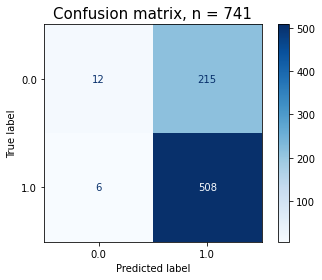

In [846]:
# confusion matrix
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

flg, ax = plt.subplots()
pcm = plot_confusion_matrix(pipe_opt, X_test, y_test,
                           cmap = plt.cm.Blues,
                           ax = ax);

plt.title(f"Confusion matrix, n = {len(y_test)}", fontsize = 15)
plt.show()

In [851]:
pipe_opt.predict(X_test)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 0., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 0., 0., 1., 1.,
       0., 0., 0., 0., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1.,
       1., 1., 1., 1., 1.

In [853]:
def vaa_score(df):
    df["close_1y_lag"] = df["close"].shift(252)
    df["close_6m_lag"] = df["close"].shift(121)
    df["close_3m_lag"] = df["close"].shift(60)
    
    df["momentum_1y"] = (df["close"] - df["close_1y_lag"]) - 1
    df["momentum_6m"] = (df["close"] - df["close_6m_lag"]) - 1
    df["momentum_3m"] = (df["close"] - df["close_3m_lag"]) - 1
    
    df["vaa_score"] = (12 * df["momentum_20"]) + (4 * df["momentum_3m"]) + (2 * df["momentum_6m"]) + (1 * df["momentum_1y"])
    
    return df

In [855]:
sp500_vaa = vaa_score(sp500_etf)

In [856]:
sp500_result = sp500_vaa[sp500_vaa["date"] >= "2018-01-01"][["date", "change", "vaa_score"]].reset_index(drop = True)
sp500_result = pd.merge(sp500_result, sp_etf["date"], on = "date", how = "inner")
sp500_result["predict"] = pipe_opt.predict(X_test)
sp500_result

,date,change,vaa_score,predict
0,2018-01-02,-0.003294,20458.227069,1.0
1,2018-01-03,0.007082,21343.227389,1.0
2,2018-01-04,0.006564,22448.229747,1.0
3,2018-01-05,0.004502,23118.359121,1.0
4,2018-01-08,0.006491,22783.525084,1.0
...,...,...,...,...
736,2021-02-01,-0.004478,34467.905252,1.0
737,2021-02-02,0.017993,36508.292479,1.0
738,2021-02-03,0.013483,36318.436566,1.0
739,2021-02-04,-0.004136,33848.187436,1.0


In [857]:
sp500_result.to_csv("sp500_result.csv")